In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def plot_fit(x,y,mu,var, m_y='k-o', m_mu='b-<', l_y='true', l_mu='predicted', legend=True, title='',output_path=None,img_id=None):
    """
    Plot the fit of a GP
    """
    fig=plt.figure(figsize=[7,5])
    if y is not None:
        plt.plot(x,y, m_y, label=l_y)

    plt.plot(x,mu, m_mu, label=l_mu)
    vv = 2*np.sqrt(var)
    plt.fill_between(x[:,0], (mu-vv)[:,0], (mu+vv)[:,0], alpha=0.2, edgecolor='gray', facecolor='cyan')
    if legend:
        plt.legend()
    if title != '':
        plt.title(title)
    fig.savefig(output_path+img_id+'.png')

In [3]:
import datetime as dt
import numpy as np
import pandas as pd
import fxcmpy
from fxcmpy import fxcmpy_tick_data_reader as tdr
import tables as tb
period='m1'
#TOKEN = '71ec67818275600cfcb24e9103f517665a313d08'
TOKEN = '5d932c9a5d3a05506ffbad22b616bb18453dbadf'
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')
#con = fxcmpy.fxcmpy(config_file='fxcm.cfg', server='demo')
#print(con.get_instruments())
data = con.get_candles('EUR/USD', period='D1',number=100)


#start = dt.datetime(2017, 1, 2)
#end = dt.datetime(2017, 1, 3)
#data = tdr('AUDCAD', start, end, verbosity=True)

In [4]:
data.head()

,bidopen,bidclose,bidhigh,bidlow,askopen,askclose,askhigh,asklow,tickqty
date,,,,,,,,,
2019-07-25 21:00:00,1.11394,1.11461,1.11871,1.11007,1.11409,1.11480,1.11883,1.11019,257037
2019-07-26 21:00:00,1.11461,1.11239,1.11505,1.11114,1.11480,1.11299,1.11517,1.11126,132825
2019-07-28 21:00:00,1.11239,1.11234,1.11299,1.11192,1.11299,1.11285,1.11335,1.11262,250
2019-07-29 21:00:00,1.11234,1.11440,1.11504,1.11123,1.11285,1.11454,1.11515,1.11136,117234
2019-07-30 21:00:00,1.11440,1.11540,1.11604,1.11314,1.11454,1.11557,1.11618,1.11326,148994


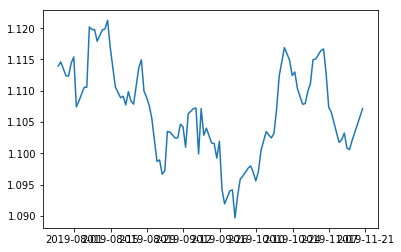

In [5]:
#
plt.plot(data['bidopen'])

In [6]:
data['bidopen'].shape

(100,)

In [7]:
ytr=np.array(data['bidopen'])
length=ytr.shape[0]
length_test=10
length_train=length-length_test
xtr=np.linspace(1,length,num=length)[:,None]
ytr=ytr[:,None]
ytr_train=ytr[0:length_train,:]
xtr_train=xtr[0:length_train,:]
ytr_test=ytr[(length_train):,:]
xtr_test=xtr[(length_train):,:]

In [8]:
#ytr_train.shape
xtr_train.shape
xtr_test.shape

(10, 1)

In [9]:
import GPy
Q = xtr_train.shape[1]
#k = RationalQuadratic(Q)
k1=GPy.kern.StdPeriodic(Q)
k2=GPy.kern.RBF(Q)
k3=GPy.kern.Linear(Q)
k4=GPy.kern.Poly(Q)

# Combining Polynomial kernal and periodic kernal

Polynomial kernal:
    $$k(x,y)=(x^T*y+c)^d$$


Periodic kernal:
    k(x,y) = $$\theta_1 \exp \left[  - \frac{1}{2} \sum_{i=1}^{input\_dim}
       \left( \frac{\sin(\frac{\pi}{T_i} (x_i - y_i) )}{l_i} \right)^2 \right]$$

In [ ]:
k=k1+k4 #polynomial kernal and periodic kernal
m = GPy.models.GPRegression(X=xtr_train, Y=ytr_train, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 50, messages=False)
display(m)

Optimization restart 1/50, f = -279.2757381274058
Optimization restart 2/50, f = -299.77839453326817
Optimization restart 3/50, f = -283.80923945798645
Optimization restart 4/50, f = -380.50558469916325


 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:131: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:invalid value encountered in sin
 /anaconda3/lib/python3.6/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:overflow encountered in true_divide
 /anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning:invalid value encountered in reduce


Optimization restart 5/50, f = -303.0138589703346
Optimization restart 6/50, f = -205.58082881906245
Optimization restart 7/50, f = -332.70328580237305
Optimization restart 8/50, f = -322.56936042722725


In [ ]:
m.plot()

In [ ]:
output_path='./report/'+period+'/'
if not os.path.exists(output_path):
    os.makedirs(output_path)
img_id='polynomial+periodical_whole'
X_star=xtr_train
Y_star=ytr_train
mu,var = m.predict(xtr)
plot_fit(xtr, ytr, mu, var,output_path=output_path,img_id=img_id)

In [ ]:
print(m)
X_star=xtr_train
Y_star=ytr_train
mu,var = m.predict(xtr)
img_id='polynomial+periodical_prediction'
plot_fit(xtr[80:,:], ytr[80:,:], mu[80:,:], var[80:,:],output_path=output_path,img_id=img_id)

In [ ]:
def RMSE(model, xpred, ypred):
    mu, V = model.predict(xpred)
    Sqerr = np.power(ypred - mu,2)
    MSE = np.sum(Sqerr)
    rmse = np.sqrt(MSE/ypred.size)
    print ('RMSE = ' +str(rmse))
    print ('Log likelihood is ' + str(model.log_likelihood()))
    return rmse
RMSE(m,xtr_test,ytr_test)


In [ ]:
mu,v=m.predict(xtr_test)
np.sqrt(np.power(ytr_test[0]-mu[0],2))

In [ ]:
#X_extrap=np.linspace(0,200,200)[:,None]
#mu,var = m.predict(X_extrap)
#plot_fit(X_extrap, None, mu, var)


# RBF Kernal


$$k(r) = \sigma^2 \exp \bigg(- \frac{1}{2} r^2 \bigg)$$

In [ ]:
k=k2
m = GPy.models.GPRegression(X=X_star, Y=Y_star, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 50, messages=False)
display(m)
m.plot() #after optimization

In [ ]:
print(m)
mu,var = m.predict(xtr)

img_id='RBF_whole'

plot_fit(xtr, ytr, mu, var,output_path=output_path,img_id=img_id)

In [ ]:
print(m)
X_star=xtr_train
Y_star=ytr_train
mu,var = m.predict(xtr)
img_id='RBF_prediction'

plot_fit(xtr[80:,:], ytr[80:,:], mu[80:,:], var[80:,:],output_path=output_path,img_id=img_id)

In [ ]:
#X_extrap=np.linspace(1,200,200)[:,None]
#mu,var = m.predict(X_extrap)
#plot_fit(X_extrap, None, mu, var)

In [ ]:
def RMSE(model, xpred, ypred):
    mu, V = model.predict(xpred)
    Sqerr = np.power(ypred - mu,2)
    MSE = np.sum(Sqerr)
    rmse = np.sqrt(MSE/ypred.size)
    print ('RMSE = ' +str(rmse))
    print ('Log likelihood is ' + str(model.log_likelihood()))
    return rmse
RMSE(m,xtr_test,ytr_test)


In [ ]:
mu,v=m.predict(xtr_test)
np.sqrt(np.power(ytr_test[0]-mu[0],2))

# Combine RBF kernal and Polynomial kernal

In [ ]:
k=k2+k1
m = GPy.models.GPRegression(X=X_star, Y=Y_star, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 50, messages=False)
display(m)
m.plot() #after optimization

In [ ]:
print(m)
mu,var = m.predict(xtr)
img_id='RBF_periodical_whole'
plot_fit(xtr, ytr, mu, var,output_path=output_path,img_id=img_id)

In [ ]:
def RMSE(model, xpred, ypred):
    mu, V = model.predict(xpred)
    Sqerr = np.power(ypred - mu,2)
    MSE = np.sum(Sqerr)
    rmse = np.sqrt(MSE/ypred.size)
    print ('RMSE = ' +str(rmse))
    print ('Log likelihood is ' + str(model.log_likelihood()))
    return rmse
RMSE(m,xtr_test,ytr_test)

In [ ]:
mu,v=m.predict(xtr_test)
np.sqrt(np.power(ytr_test[0]-mu[0],2))

In [ ]:
print(m)
X_star=xtr_train
Y_star=ytr_train
mu,var = m.predict(xtr)
img_id='RBF+periodical_prediction'

plot_fit(xtr[80:,:], ytr[80:,:], mu[80:,:], var[80:,:],output_path=output_path,img_id=img_id)

In [ ]:
#X_extrap=np.linspace(1,200,200)[:,None]
#mu,var = m.predict(X_extrap)
#plot_fit(X_extrap, None, mu, var)

# Combine linear kernal and periodic kernal

The linear kernal is defined as:
$$k(x,y) = \sum_{i=1}^{\text{input_dim}} \sigma^2_i x_iy_i$$

In [ ]:
k=k3+k1
m = GPy.models.GPRegression(X=X_star, Y=Y_star, kernel=k)
m.plot() #before optimization
m.optimize(messages=False)
m.optimize_restarts(num_restarts = 50, messages=False)
display(m)
m.plot() #after optimization

In [ ]:
def RMSE(model, xpred, ypred):
    mu, V = model.predict(xpred)
    Sqerr = np.power(ypred - mu,2)
    MSE = np.sum(Sqerr)
    rmse = np.sqrt(MSE/ypred.size)
    print ('RMSE = ' +str(rmse))
    print ('Log likelihood is ' + str(model.log_likelihood()))
    return rmse
RMSE(m,xtr_test,ytr_test)

In [ ]:
mu,v=m.predict(xtr_test)
np.sqrt(np.power(ytr_test[0]-mu[0],2))

In [ ]:
print(m)
mu,var = m.predict(xtr)
img_id='RBF+periodical_whole'
plot_fit(xtr, ytr, mu, var,output_path=output_path,img_id=img_id)

In [ ]:
print(m)
X_star=xtr_train
Y_star=ytr_train
mu,var = m.predict(xtr)
img_id='RBF+periodical_prediction'
plot_fit(xtr[80:,:], ytr[80:,:], mu[80:,:], var[80:,:],output_path=output_path,img_id=img_id)

In [ ]:
#X_extrap=np.linspace(1,200,200)[:,None]
#mu,var = m.predict(X_extrap)
#plot_fit(X_extrap, None, mu, var)